In [32]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import hamming
from scipy.optimize import linear_sum_assignment
from time import time
sns.set()
# Import Tabu Sampler
from tabu_class import tabu_sampler

@numba.njit()
def autocorr(x, lags):
    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]

    return np.array(corr)

In [33]:
n = 500
lamb = 5
half_vals = int(1/2 * (n*(n-1)))

w_matrix = np.random.lognormal(size=n**2, mean = 0, sigma = lamb).reshape(n, n)
mode = linear_sum_assignment(-np.log(w_matrix) + np.min(np.log(w_matrix)))[1]

# Calculate locally balanced weights
w_matrix_g = w_matrix
#w_matrix_g = w_matrix/(1+w_matrix)

# Calculate Rates
def neighbour_generator(perm, weights=w_matrix):
    nem_ret = np.zeros(int(n*(n-1)/2))
    pos = 0
    
    # Calculates the log-probability change for each permutation
    for i in np.arange(0, n):
        for j in np.arange(i+1, n):
            # Update energies
            pi_y = weights[i,perm[j]]*weights[j, perm[i]]
            pi_x = weights[i,perm[i]]*weights[j,perm[j]]
            nem_ret[pos] = pi_y/(pi_y + pi_x)
            pos += 1
            
    # Placeholder for calculations
    zanella_matrix = np.zeros((n, n))
    
    # Insert exponentiated values
    zanella_matrix[np.triu_indices(n, 1)] = nem_ret 
    # Insert below the diagonal
    zanella_matrix[np.tril_indices(n, -1)] += zanella_matrix.T[np.tril_indices(n, -1)]
    
    # Reshape to return
    zanella_matrix_return = zanella_matrix.reshape(n**2,)
    
    return zanella_matrix_return

# Energy function
@numba.njit()
def target_measure(perm, weights=w_matrix):
    init = 0
    for i in np.arange(0, n):
        init += np.log(weights[i, perm[i]])
        
    return -init

# Apply generator
def switch_perm(perm, swap_id, n=n):
    i = int(np.floor(swap_id/n))
    j = swap_id % n
    #print("Swap ID:", i, j)
    perm_store = perm.copy()
    perm_store[j] = perm_store[i]
    perm_store[i] = perm[j]
    
    return perm_store

# Update Rates
def update_zanella_matrix(perm, current_rates, current_rates_sum, swap_id, w_matrix_g=w_matrix_g, n=n):
    # Convert swap_id into i, j position in Z_matrix
    i_swap = int(np.floor(swap_id/n))
    j_swap = swap_id % n
    
    # Create zanella_matrix
    zanella_matrix_g = current_rates.reshape(n,n)
    
    # Update Zanella matrix
    zanella_matrix_g[i_swap, :] = w_matrix_g[i_swap, perm] * w_matrix_g[np.arange(0, n), perm[i_swap]] / (w_matrix_g[i_swap, perm] * w_matrix_g[np.arange(0, n), perm[i_swap]] + w_matrix_g[i_swap, perm[i_swap]] * w_matrix_g[np.arange(0, n), perm])
    zanella_matrix_g[:, i_swap] = zanella_matrix_g[i_swap, :].T

    zanella_matrix_g[j_swap, :] = w_matrix_g[j_swap, perm] * w_matrix_g[np.arange(0, n), perm[j_swap]] / (w_matrix_g[j_swap, perm] * w_matrix_g[np.arange(0, n), perm[j_swap]] + w_matrix_g[j_swap, perm[j_swap]] * w_matrix_g[np.arange(0, n), perm])
    zanella_matrix_g[:, j_swap] = zanella_matrix_g[j_swap, :].T
    
    # Fix diagonal
    zanella_matrix_g[i_swap, i_swap] = 0
    zanella_matrix_g[j_swap, j_swap] = 0
    # Remove both possibilities

    return zanella_matrix_g.reshape(n**2,)

In [34]:
T = 3000
thinning_ratio = 0.03
N = int(T/thinning_ratio)
samples, energy, hammings, alpha, iters, runtime = tabu_sampler(n, int(n**2), 
                                                   energy_function=target_measure, 
                                                   calculate_rates=neighbour_generator, 
                                                   update_rates=update_zanella_matrix, 
                                                   apply_generator=switch_perm, 
                                                   current_state=np.arange(0, n), 
                                                   baseline_state=mode, 
                                                   target_time=T, 
                                                   thin_rate=thinning_ratio, 
                                                   time_change_rate=10e-10,
                                                   SAW_bool=True)

Percent: [--------------------------------------->] 100%[3000.02042989]
Average SAW length: 12.0
Average jump length: [0.029007]
Runtime: 656.79


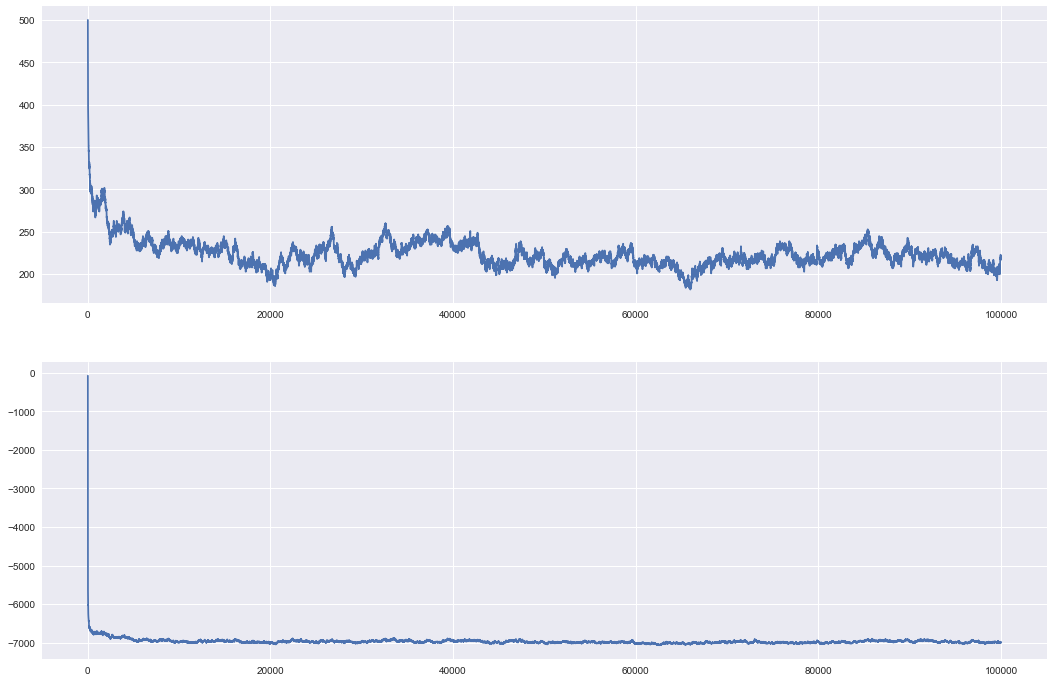

In [4]:
%matplotlib inline
plt.figure(figsize=(18,12))
plt.subplot(2, 1, 1)
plt.plot(hammings[:])
plt.subplot(2, 1, 2)
plt.plot(energy[:])

0.04524458767313475


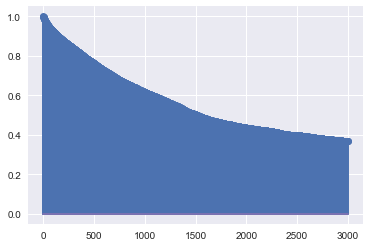

In [35]:
fig, ax = plt.subplots()
ax.stem(autocorr(hammings[int(0.2*N):], np.arange(0, 3000)))
ESS_HD = N/(1+2*sum(autocorr(hammings[int(0.2*N):], np.arange(0, 3000))))
print(ESS_HD/runtime)

0.058843987728313854


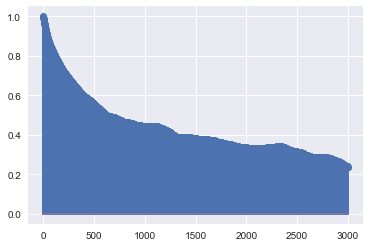

In [6]:
fig, ax = plt.subplots()
ax.stem(autocorr(energy[int(0.2*N):], np.arange(0, 3000)))
ESS_HD_Z = N/(1+2*sum(autocorr(energy[int(0.2*N):], np.arange(0, 3000))))
print(ESS_HD_Z/runtime)

cZanella

In [36]:
T = 1500
thinning_ratio = 0.0150
N = int(T/thinning_ratio)
samples_z, energy_z, hammings_z, alpha, iters_z, runtime_z = tabu_sampler(n, int(n**2), 
                                                   energy_function=target_measure, 
                                                   calculate_rates=neighbour_generator, 
                                                   update_rates=update_zanella_matrix, 
                                                   apply_generator=switch_perm, 
                                                   current_state=np.arange(0, n), 
                                                   baseline_state=mode, 
                                                   target_time=T, 
                                                   thin_rate=thinning_ratio, 
                                                   time_change_rate=7,
                                                   SAW_bool=False)

Percent: [--------------------------------------->] 100%[1500.04920058]
Average jump length: [0.01740015]
Runtime: 588.7


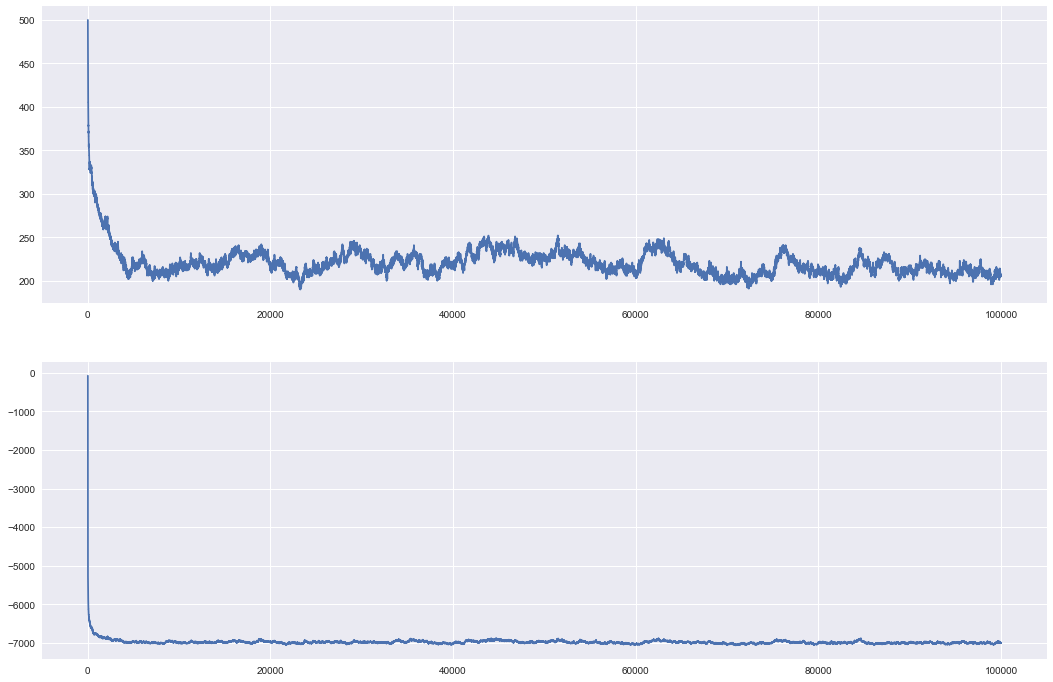

In [8]:
plt.figure(figsize=(18,12))
plt.subplot(2, 1, 1)
plt.plot(hammings_z[:])
plt.subplot(2, 1, 2)
plt.plot(energy_z[:])

0.0458975261036237


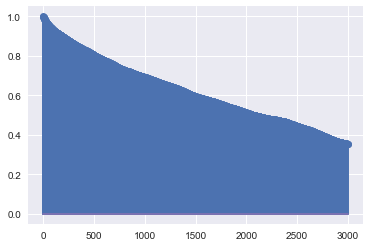

In [37]:
fig, ax = plt.subplots()
ax.stem(autocorr(hammings_z[int(0.2*N):], np.arange(0, 3000)))
ESS_HD_Z = N/(1+2*sum(autocorr(hammings_z[int(0.2*N):], np.arange(0, 3000))))
print(ESS_HD_Z/runtime_z)

0.08995162702373369


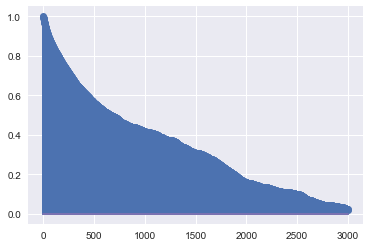

In [10]:
fig, ax = plt.subplots()
ax.stem(autocorr(energy_z[int(0.2*N):], np.arange(0, 3000)))
ESS_HD_Z = N/(1+2*sum(autocorr(energy_z[int(0.2*N):], np.arange(0, 3000))))
print(ESS_HD_Z/runtime_z)